In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import neural
import copy

# Main Ideas

The configuration for trainig a neural network is given by a neural.CompleteConfig. This configuration is composed by 3 elements:

- model_config, an instace of nn.ModelConfig, which specifies how a neural network should be first constructed. At the moment,
    this is used to set the layers and the activation function.

- trainer_config, an instance of nn.TrainerConfig, that is used to set the optimizer, the learning rate scheduler, the parameters
    of the training (for example, number of epochs or relative weight of each loss function) and a setup function that can modify
    these parameters at each epoch.

- loss_blocks, a dictionary of neural.LossBlock. A loss block contains all the data necessary to compute one specific loss of the 
    model. Its elements are: x, y and w, which are the test points, expected outputs and weight of each point. Also, a dictionary
    of parameters and a setup function that can modify the loss block at each epoch.
    

In order to define a complete configuration, it is necessary to define these 3 elements.

However, first we need the functions used in the training, which can only be kept as python functions.

# Define functions

Although we can store a lot of stuff as json files, functions must be defined purely as python functions.

## Define loss functions

This block defines a collection of loss functions. A loss function takes 4 arguments:

- **model:** *nn.neural.Module*

    The model that we are training, which for an input of size r_in produces an
    output of size r_out.


- **x:** *torch.Tensor*

    The points where the neural model is evaluated, that is, the input to the model
    used to compute the loss. It must have shape (r_in x N), where N is the number of
    points used for the loss, each one being a column in the input. For our problem,
    the input is [x; t].

    
- **y:** *torch.Tensor*

    A tensor with shape [y_size x N] used to test the output of model(x). Usually,
    we would have [nn_out x N] if we now the value that the model must produce for
    each x. However, we can also specify only voltage, or current, or use None if no
    y is used to compute the loss, like in the case of the loss of the differential
    equation.
    

- **parameters:** *dict*

    A dictionary that can be modified during setup or training, and is used to provide
    constants to the equations.

In [2]:
def voltage_loss_function(model, x, y, parameters):
    """Squared difference of the obtained and expected voltage at the given points
    
        Simplest example of a loss function, it computes the voltage given by the model
        at points x, the expected voltage given in y, and takes the squared error. This
        is used to impose voltage at the boundaries.
    """
    return torch.square(model(x)[0,:] - y)


def full_zero_loss_function(model, x, _, parameters):
    """Squared voltage plus squared current at x

        Similar to voltage_loss_function, but it also adds the current. Can be used
        to impose clean initial conditions
    """
    y_nn = model(x)
    return torch.sum(torch.square(y_nn), 0)


def voltage_and_current_relation_loss_function(model, x, _, parameters):
    """Squared difference of the relation between the voltage and current

        This is used to impose V = I * R, usually at the receiving end of the transmission
        line. No y is specified, since the error is obtained just from voltage and current
        obtained by the model.
    """
    output = model(x)
    return torch.square(output[0,:]/parameters["RL"] - output[1,:])


def physics_loss_function(model, x, _, parameters):
    """Imposes the voltage and current to follow telegrapher's equation

        This is where the physics enter. Taking a bunch of gradients, we obtain the error in the
        differential equations at the test points x, and square them.
    """

    y_nn = model(x)
    v = y_nn[0, :]
    i = y_nn[1, :]
    
    # Hard-coded parameters, should not stay like this!
    L = parameters["L"] # 3.0
    C = parameters["C"] # 3.0
    R = parameters["R"] #0.01
    G = parameters["G"] # 1/10**5, eventually this should come out of the model too
    gamma = parameters["gamma"]

    grad_v = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    grad_i = torch.autograd.grad(i, x, grad_outputs=torch.ones_like(i), retain_graph=True, create_graph=True)[0]
    v_x = grad_v[0, :]
    v_t = grad_v[1, :]
    i_x = grad_i[0, :]
    i_t = grad_i[1, :]

    grad_v_x = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), retain_graph=True)[0]
    grad_i_x = torch.autograd.grad(i_x, x, grad_outputs=torch.ones_like(i_x), retain_graph=True)[0]
    v_xx = grad_v_x[0,:]
    i_xx = grad_i_x[0,:]
    
    eq_1_error = v_x + L * i_t + R * i + gamma * i_xx
    eq_2_error = i_x + C * v_t + G * v + gamma * v_xx
    
    return torch.square(eq_1_error) + torch.square(eq_2_error)


## Define setup functions

Setup functions are called at every epoch. So far there are two kind of setup functions:

### Loss function setup:
They are used to set the x, y and w of their associated loss functions
(that is, the input or test points, the expected values, and the weight of each point).
Also, they set the parameters of the same loss function.

A loss function setup takes 3 arguments:

- loss_block: neural.LossBlock

    The loss block associated to the setup, which gives access to its parameters, x, y and w.


- stats: neural.TrainingStats

    Gives access to the losses obtained in the last epoch, and the overall evolution of the losses.
    This can be used to setup the weight of each training point depending on its loss in the last
    iteration.


- epoch: int

    The number of epoch.



### Training setup

They modify the parameters that affect the overall training, like the relative weight of each
loss function in the total loss. For the most part, they just initialize x, y and w in the first
epoch.
    


In [3]:
def bc_left_setup(loss_block: neural.LossBlock, stats, epoch):
    """
        For the left_bc, we only initialize this loss by setting up the test points.
    """
    if epoch == 0:
        n_points = loss_block.parameters["n_points"]
        loss_block.x = torch.stack((torch.zeros(n_points), torch.linspace(0, 10, n_points)), 0)
        t = torch.linspace(0, 10, n_points)
        # loss_block.y = torch.sin(t-2) * torch.exp(-(t-2)**2)
        # loss_block.y = torch.sin(t)    
        loss_block.y = (1-torch.cos(np.pi/3 * t))/2
        loss_block.w = torch.ones(n_points)/n_points

        return

def voltage_at_right_bc_setup(loss_block: neural.LossBlock, stats, epoch):
    """
        For the right, we do something similar
    """
    if epoch == 0:
        n_points = loss_block.parameters["n_points"]
        loss_block.x = torch.stack((torch.ones(n_points), torch.linspace(0, 10, n_points)), 0)
        loss_block.y = torch.zeros(n_points)
        loss_block.y[80:100] = 2
        loss_block.w = torch.ones(n_points)

def bc_right_setup(loss_block: neural.LossBlock, stats, epoch):
    """Just distributes points x uniformly along time in the receiving end of the transmission line
    
    """
    if epoch == 0:
        n_points = loss_block.parameters["n_points"]
        loss_block.x = torch.stack((torch.ones(n_points), torch.linspace(0, 10, n_points)), 0)
        loss_block.y = None
        loss_block.w = torch.ones(n_points)

def ic_setup(loss_block: neural.LossBlock, stats, epoch):
    """Just distributes points x uniformly along the transmission line for time 0.
    
    """
    if epoch == 0:
        n_points = loss_block.parameters["n_points"]
        loss_block.x = torch.stack((torch.linspace(0, 1, n_points), torch.zeros(n_points)), 0)
        loss_block.y = None
        loss_block.w = torch.ones(n_points)


def physics_setup(loss_block: neural.LossBlock, stats, epoch):
    """
        They physics testing points (or residual points) are sampled from the
        domain unformly. Additionally, the can be resapled
    """
    if epoch == 0:
        n_points = loss_block.parameters["n_points"]
        loss_block.x = torch.rand((2, n_points))
        loss_block.x[1, :] = 10 * loss_block.x[1, :]
        loss_block.x.requires_grad_(True)
        loss_block.y = None
        return
    

    resample_period = loss_block.parameters["resample_period"]

    if resample_period is not None and epoch % resample_period == 0:
        # Resamples the test points 
        n_points = loss_block.parameters["n_points"]
        loss_block.x = torch.rand((2, n_points))
        loss_block.x[1, :] = 10 * loss_block.x[1, :]
        loss_block.x.requires_grad_(True)
        loss_block.y = None
        

    reweighting_period = loss_block.parameters["reweighting_period"]

    if reweighting_period is not None and epoch % reweighting_period == 0:
        # Changes the weights of the losses according to some weird rule I forgot
        initial_ratio = loss_block.parameters["initial_ratio"]
        final_ratio = loss_block.parameters["final_ratio"]
        alpha = epoch/40000
        time_array = loss_block.x[1,:]
        loss_block.w = -torch.pow(initial_ratio * (1-alpha) + final_ratio*alpha, time_array/10)
        loss_block.w = loss_block.w/torch.sum(loss_block.w)

# Trainer setup function

"""
    The training update is similar to the loss block update, but for the training procedure.
    The state of the trainer involves stuff like the relative weight of the different losses
"""
def update_training(trainer_config: neural.TrainerConfig, stats, epoch):
    pass

# Configuration

This is the actual configuration of the training, which can be stored as a JSON.

In [4]:
bc_left_parameters= { "loss_function_parameters": {}, "n_points": 200}
bc_right_parameters = { "loss_function_parameters": { "RL": 3 }, "n_points": 200}
ic_parameters = {"loss_function_parameters": {}, "n_points": 200}

bc_right_imposed_parameters = {
    "loss_function_parameters": { },
    "n_points": 200
}

physics_parameters = {
    "loss_function_parameters": {
        "gamma": 0.0,
        "L": 3.0,
        "C": 3.0,
        "R": 0.01,
        "G": 1/10**5        
    },
    "n_points": 8000,
    "resample_period": None,
    "reweighting_period": None,
    "initial_ratio": 8,
    "final_ratio": 1
}

trainer_parameters = {
    "n_epochs": 40000,
    "loss_weights": {
        "bc_left": 1.0,
        "bc_right": 1.0,
        "ic": 1.0,
        "physics": 1.0
    }
}   

bc_left_loss_block = neural.LossBlock("voltage_loss_function", "bc_left_setup", bc_left_parameters)
bc_right_loss_block = neural.LossBlock("voltage_and_current_relation_loss_function", "bc_right_setup", bc_right_parameters)
ic_loss_block = neural.LossBlock("ic_function", "ic_setup", ic_parameters)
physics_loss_block = neural.LossBlock("physics_loss_function", "physics_setup", physics_parameters)

bc_right_imposed_loss_block = neural.LossBlock("bc_right_imposed_function", "bc_right_imposed_setup", bc_right_imposed_parameters)


model_config = neural.ModelConfig(
    [2, 10, 10, 10, 10, 2],
    "torch.tanh"
)

base_trainer_config = neural.TrainerConfig(
    optimizer_config=neural.OptimizerConfig("torch.optim.Adam", lr=0.001),
    lr_scheduler_config=None,
    update_function="update_training",
    parameters=trainer_parameters,
)

# # Training with scheduler
# scheduled_trainer_config = neural.TrainerConfig(
#     optimizer_config=neural.OptimizerConfig("torch.optim.Adam", lr=0.005),
#     lr_scheduler_config=neural.LrSchedulerConfig("torch.optim.lr_scheduler.LinearLR", start_factor=1, end_factor=0.1, total_iters=30000),
#     update_function="update_training",
#     parameters=trainer_parameters,
# )

loss_blocks = {
    "bc_left": bc_left_loss_block,
    "bc_right": bc_right_loss_block,
    "ic": ic_loss_block,
    "physics": physics_loss_block,
    # "bc_right_imposed": bc_right_imposed_loss_block
}

function_dictionary = {
    "torch.optim.Adam": torch.optim.Adam,
    "torch.optim.lr_scheduler.LinearLR": torch.optim.lr_scheduler.LinearLR,
    "torch.tanh": torch.tanh,  # Ensure this line is present
    "update_training": update_training,
    "voltage_loss_function": voltage_loss_function,
    "voltage_and_current_relation_loss_function": voltage_and_current_relation_loss_function,
    "bc_left_setup": bc_left_setup,
    "bc_right_imposed_setup": voltage_at_right_bc_setup,
    "bc_right_function": voltage_and_current_relation_loss_function,
    "bc_right_setup": bc_right_setup,
    "ic_function": full_zero_loss_function,
    "ic_setup": ic_setup,
    "physics_loss_function": physics_loss_function,
    "physics_setup": physics_setup,
    "bc_right_imposed_function": bc_right_setup,
}

sa_lr = 1e-3 # SA-PINN learning rate 

complete_config = neural.CompleteConfig(model_config, base_trainer_config, loss_blocks, function_dictionary, sa_lr=sa_lr)

complete_config.save_json("the_config.json")

In [5]:
all_models = []
all_stats = []

for i in range(1):
    loaded_config = neural.CompleteConfig.load_json("the_config.json", function_dictionary)
    final_model, stats, processed_config = loaded_config.train_model(switch_epoch=30000)  # Add switch_epoch here
    all_models.append(final_model)
    all_stats.append(stats)

Epoch 0: Total Loss: 1.5502920150756836
Epoch 5000: Total Loss: 0.002865866757929325
Epoch 10000: Total Loss: 0.0006440505385398865
Epoch 15000: Total Loss: 0.0003200694336555898
Epoch 20000: Total Loss: 0.00022086570970714092
Epoch 25000: Total Loss: 0.00021907969494350255
Epoch 30000: Total Loss: 0.00014195556286722422
Epoch 35000: Total Loss: 0.00012230945867486298


In [6]:
bc_left_parameters= { "loss_function_parameters": {}, "n_points": 200}
bc_right_parameters = { "loss_function_parameters": { "RL": 3 }, "n_points": 200}
ic_parameters = {"loss_function_parameters": {}, "n_points": 200}

bc_right_imposed_parameters = {
    "loss_function_parameters": { },
    "n_points": 200
}

physics_parameters = {
    "loss_function_parameters": {
        "gamma": 0.0,
        "L": 3.0,
        "C": 3.0,
        "R": 0.01,
        "G": 1/10**5        
    },
    "n_points": 8000,
    "resample_period": None,
    "reweighting_period": None,
    "initial_ratio": 8,
    "final_ratio": 1
}

trainer_parameters = {
    "n_epochs": 40000,
    "loss_weights": {
        "bc_left": 1.0,
        "bc_right": 1.0,
        "ic": 1.0,
        "physics": 1.0
    }
}   

bc_left_loss_block = neural.LossBlock("voltage_loss_function", "bc_left_setup", bc_left_parameters, use_sa_weights=True)
bc_right_loss_block = neural.LossBlock("voltage_and_current_relation_loss_function", "bc_right_setup", bc_right_parameters, use_sa_weights=True)
ic_loss_block = neural.LossBlock("ic_function", "ic_setup", ic_parameters, use_sa_weights=True)
physics_loss_block = neural.LossBlock("physics_loss_function", "physics_setup", physics_parameters, use_sa_weights=True)
bc_right_imposed_loss_block = neural.LossBlock("bc_right_imposed_function", "bc_right_imposed_setup", bc_right_imposed_parameters, use_sa_weights=False)


model_config = neural.ModelConfig(
    [2, 10, 10, 10, 10, 2],
    "torch.tanh"
)

base_trainer_config = neural.TrainerConfig(
    optimizer_config=neural.OptimizerConfig("torch.optim.Adam", lr=0.001),
    lr_scheduler_config=None,
    update_function="update_training",
    parameters=trainer_parameters,
)

# # Training with scheduler
# scheduled_trainer_config = neural.TrainerConfig(
#     optimizer_config=neural.OptimizerConfig("torch.optim.Adam", lr=0.005),
#     lr_scheduler_config=neural.LrSchedulerConfig("torch.optim.lr_scheduler.LinearLR", start_factor=1, end_factor=0.1, total_iters=30000),
#     update_function="update_training",
#     parameters=trainer_parameters,
# )

loss_blocks = {
    "bc_left": bc_left_loss_block,
    "bc_right": bc_right_loss_block,
    "ic": ic_loss_block,
    "physics": physics_loss_block,
    # "bc_right_imposed": bc_right_imposed_loss_block
}

function_dictionary = {
    "torch.optim.Adam": torch.optim.Adam,
    "torch.optim.lr_scheduler.LinearLR": torch.optim.lr_scheduler.LinearLR,
    "torch.tanh": torch.tanh,
    "update_training": update_training,
    "voltage_loss_function": voltage_loss_function,
    "voltage_and_current_relation_loss_function": voltage_and_current_relation_loss_function,
    "bc_left_setup": bc_left_setup,
    "bc_right_imposed_setup": voltage_at_right_bc_setup,
    "bc_right_function": voltage_and_current_relation_loss_function,
    "bc_right_setup": bc_right_setup,
    "ic_function": full_zero_loss_function,
    "ic_setup": ic_setup,
    "physics_loss_function": physics_loss_function,
    "physics_setup": physics_setup,
    "bc_right_imposed_function": bc_right_setup,
}

complete_config = neural.CompleteConfig(model_config, base_trainer_config, loss_blocks, function_dictionary)

complete_config.save_json("the_config.json")

c:\Users\AZAMM\Anaconda3\envs\PINN\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Loss per category')

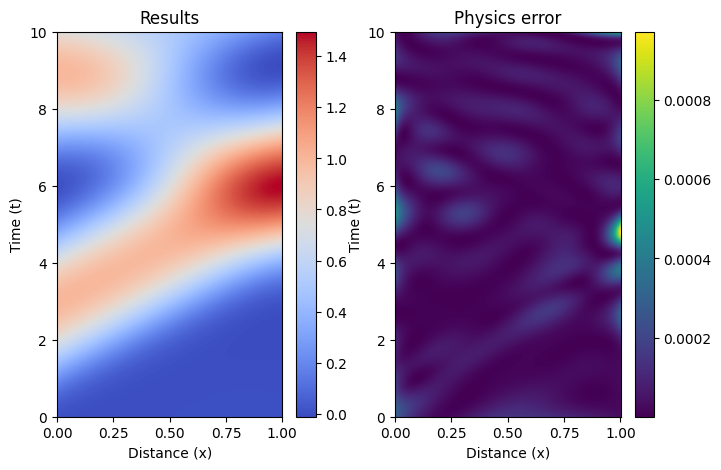

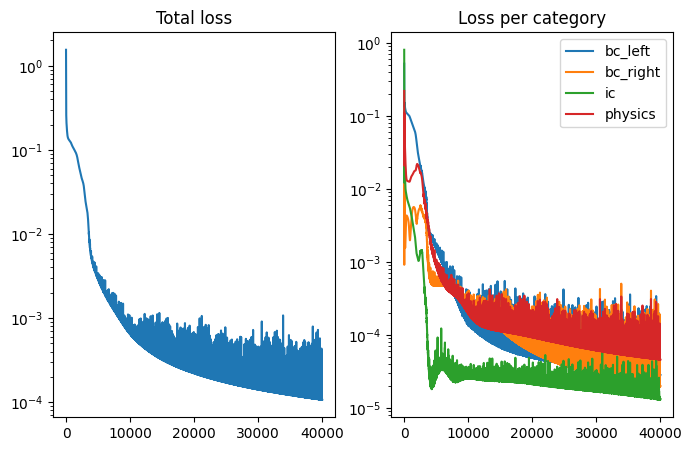

In [7]:
x_test = torch.linspace(0, 1, 2000)
t_test = torch.linspace(0, 10, 2000)

X, Y = torch.meshgrid(x_test, t_test)
in_test = torch.stack((X.reshape(-1), Y.reshape(-1)), 0)

with torch.no_grad():
    out = final_model(in_test)

fig = plt.figure(figsize=(8, 5))
axes = fig.subplots(1, 2)

img = axes[0].pcolormesh(
    X, Y, out[0,:].reshape(2000, 2000),
    cmap="coolwarm",
    # vmin=-2.5,
    # vmax=2.5
    )
# axes[0].scatter(residual_points[0,:].detach().numpy(), residual_points[1,:].detach().numpy(), s=1, c="g")
fig.colorbar(img)

in_test.requires_grad_(True)
phys_error = physics_loss_function(final_model, in_test, None, physics_parameters["loss_function_parameters"])

img = axes[1].pcolormesh(X, Y, phys_error.reshape(2000, 2000).detach().numpy())
fig.colorbar(img)

axes[0].set_title("Results")
axes[0].set_xlabel("Distance (x)")
axes[0].set_ylabel("Time (t)")

axes[1].set_title("Physics error")
axes[1].set_xlabel("Distance (x)")
axes[1].set_ylabel("Time (t)")

fig = plt.figure(figsize=(8, 5))
axes = fig.subplots(1, 2)
epochs = np.arange(complete_config.trainer_config.parameters["n_epochs"])
axes[0].semilogy(epochs, stats.total_loss_array)

labels = []
for name, loss in stats.loss_per_block.items():
    axes[1].semilogy(epochs, loss)
    labels.append(name)
    
axes[1].legend(labels)

axes[0].set_title("Total loss")
axes[1].set_title("Loss per category")

In [8]:
import time
start = time.time_ns()
np.linalg.inv(np.random.uniform(-5, 5, (3900, 3900)))
print((time.time_ns() - start)/10**9)

17.5268071


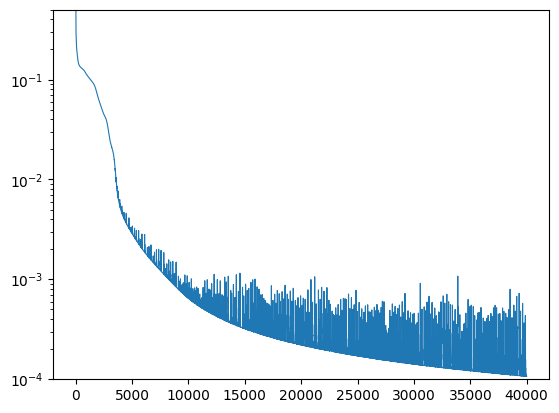

In [9]:
fig = plt.figure()
ax = fig.subplots()
for stat in all_stats:
    total_loss = stat.total_loss_array
    n_points = len(stat.total_loss_array)
    ax.semilogy(
        np.arange(n_points),
        total_loss,
        linewidth=0.8
    )
    ax.set_ylim(10**-4, 5*10**-1)

In [10]:
import sys
dict = final_model.state_dict()
print(sys.getsizeof(dict))
print(dict)

872
OrderedDict([('Ws.0', tensor([[ 0.2104,  0.1750],
        [ 0.3256,  0.0736],
        [-0.7843,  0.2834],
        [-0.9825,  0.2346],
        [ 0.2692, -0.3403],
        [-0.5934, -0.2226],
        [-0.4809,  0.3429],
        [-0.5002,  0.1116],
        [-0.1088, -0.1143],
        [-1.4015,  0.4422]])), ('Ws.1', tensor([[ 0.0956, -0.1308,  0.2117,  0.0605,  0.0122,  0.2472,  0.3934,  0.6739,
         -0.4821,  0.0422],
        [-0.2739,  2.1334,  0.2900, -0.0748,  0.2897, -0.2138,  0.0428, -0.4709,
         -1.7066, -0.3239],
        [ 0.2786,  0.6929, -0.3401,  0.0841,  0.0876, -0.3682, -0.3531,  0.1016,
         -0.7277,  0.3254],
        [ 0.3920,  0.0386,  0.0378, -0.3062, -0.1132,  0.2357, -0.6007, -0.3430,
         -0.1880, -0.0329],
        [ 0.1568, -0.0691, -0.4752, -0.1447,  0.1175,  0.0714,  0.3571, -0.4227,
          0.1306, -0.2402],
        [-0.3931, -0.0812, -0.3187, -0.1535, -0.3257, -0.3223, -0.1063, -0.1959,
          0.4578, -0.2875],
        [ 0.8430,  0.1980,  

In [14]:
# Function to train a model with a given configuration
def train_model(config_path, function_dictionary, switch_epoch=30000):
    loaded_config = neural.CompleteConfig.load_json(config_path, function_dictionary)
    final_model, stats, processed_config = loaded_config.train_model(switch_epoch=switch_epoch)
    return final_model, stats, processed_config

# Second training loop
vanilla_loss_blocks = {
    "bc_left": neural.LossBlock("voltage_loss_function", "bc_left_setup", bc_left_parameters, use_sa_weights=False),
    "bc_right": neural.LossBlock("voltage_and_current_relation_loss_function", "bc_right_setup", bc_right_parameters, use_sa_weights=False),
    "ic": neural.LossBlock("ic_function", "ic_setup", ic_parameters, use_sa_weights=False),
    "physics": neural.LossBlock("physics_loss_function", "physics_setup", physics_parameters, use_sa_weights=False),
    # "bc_right_imposed": neural.LossBlock("bc_right_imposed_function", "bc_right_imposed_setup", bc_right_imposed_parameters, use_sa_weights=False)
}

vanilla_complete_config = neural.CompleteConfig(model_config, base_trainer_config, vanilla_loss_blocks, function_dictionary)
vanilla_complete_config.save_json("vanilla_config.json")

vanilla_models = []
vanilla_stats = []

for i in range(1):
    final_model, stats, processed_config = train_model("vanilla_config.json", function_dictionary, switch_epoch=5000)  # Add switch_epoch here
    vanilla_models.append(final_model)
    vanilla_stats.append(stats)

# Train SA-PINN (use_sa_weights=True)
sa_loss_blocks = {
    "bc_left": neural.LossBlock("voltage_loss_function", "bc_left_setup", bc_left_parameters, use_sa_weights=True),
    "bc_right": neural.LossBlock("voltage_and_current_relation_loss_function", "bc_right_setup", bc_right_parameters, use_sa_weights=True),
    "ic": neural.LossBlock("ic_function", "ic_setup", ic_parameters, use_sa_weights=False),
    "physics": neural.LossBlock("physics_loss_function", "physics_setup", physics_parameters, use_sa_weights=True),
    # "bc_right_imposed": neural.LossBlock("bc_right_imposed_function", "bc_right_imposed_setup", bc_right_imposed_parameters, use_sa_weights=True)
}

sa_lr = 0.001  # Define a separate learning rate for SA weights

sa_complete_config = neural.CompleteConfig(model_config, base_trainer_config, sa_loss_blocks, function_dictionary, sa_lr=sa_lr)
sa_complete_config.save_json("sa_config.json")

sa_models = []
sa_stats = []
sa_weights = []

for i in range(1):
    final_model, stats, processed_config = train_model("sa_config.json", function_dictionary, switch_epoch=5000)  # Add switch_epoch here
    sa_models.append(final_model)
    sa_stats.append(stats)
    sa_weights.append({
        name: {
            "weights": block.sa_weights.detach().cpu().numpy(),
            "positions": block.x.detach().cpu().numpy()
        }
        for name, block in processed_config.loss_blocks.items() if block.use_sa_weights
    })

Epoch 0: Total Loss: 3.722346782684326
Epoch 5000: Total Loss: 0.008804832585155964
Epoch 10000: Total Loss: 0.0017608297057449818
Epoch 15000: Total Loss: 0.0023503319825977087
Epoch 20000: Total Loss: 0.0004444817313924432
Epoch 25000: Total Loss: 0.000357824785169214
Epoch 30000: Total Loss: 0.0002805707626976073
Epoch 35000: Total Loss: 0.0003801662242040038
Epoch 0: Total Loss: 6.2646098136901855
Epoch 5000: Total Loss: 0.006783423945307732
Epoch 10000: Total Loss: 0.0015511150704696774
Epoch 15000: Total Loss: 0.0004934010794386268
Epoch 20000: Total Loss: 0.00019506452372297645
Epoch 25000: Total Loss: 0.0003059841401409358
Epoch 30000: Total Loss: 0.00010033627040684223
Epoch 35000: Total Loss: 8.985934982774779e-05


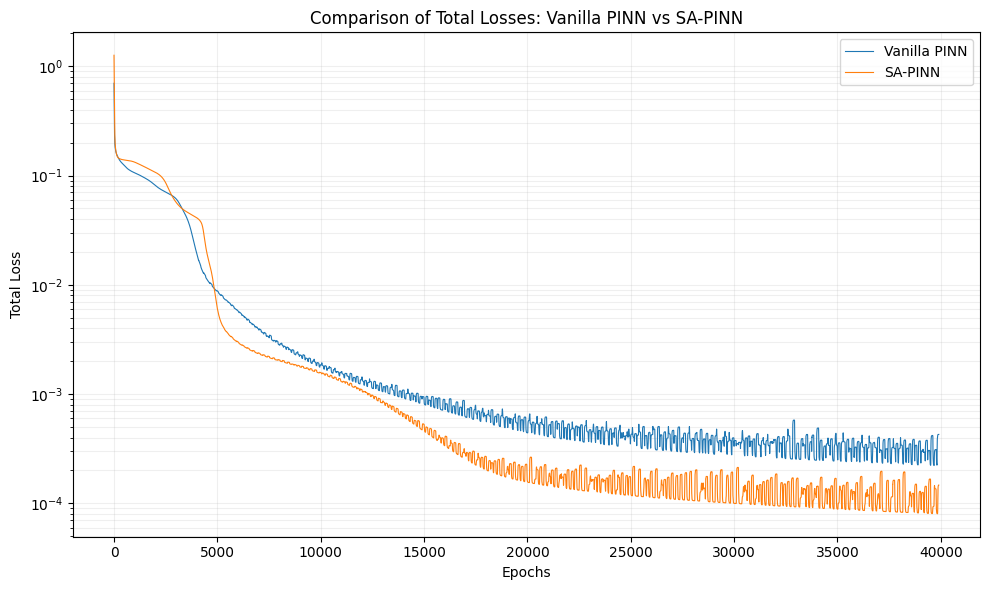

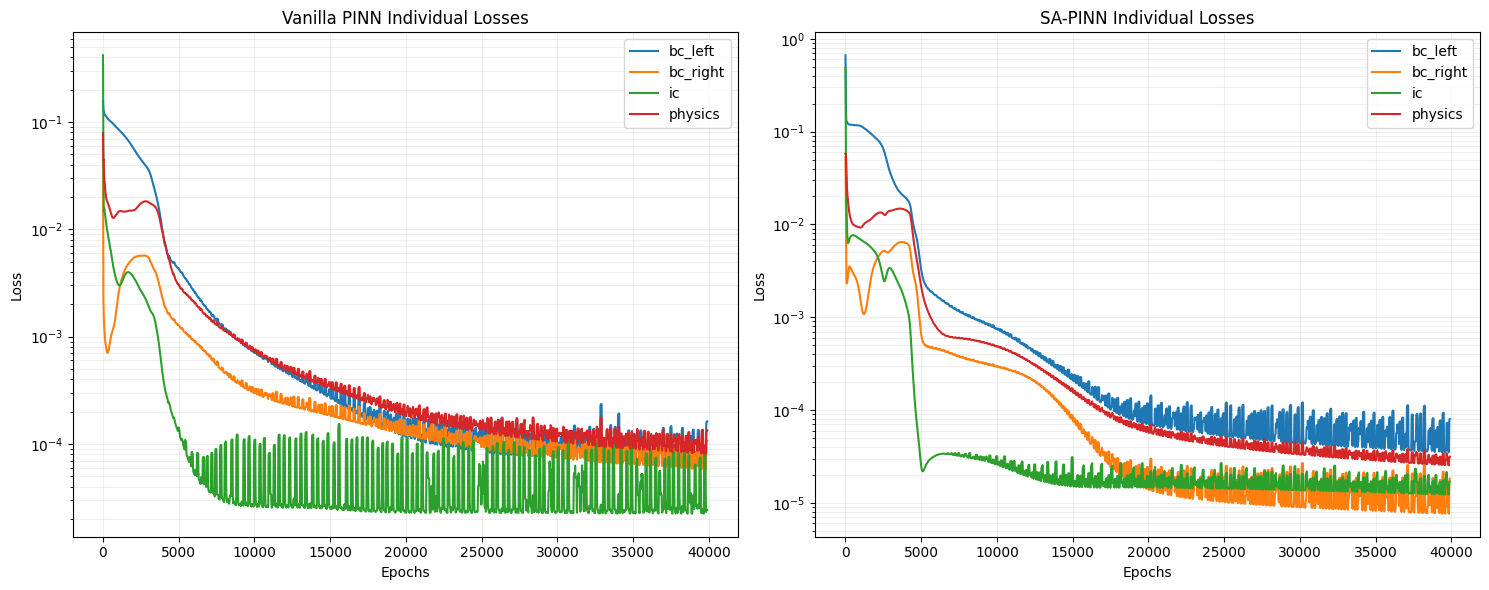

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size):
    """Compute the moving average of a 1D array."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Define the window size for smoothing
window_size = 100

# Plot the comparison of total losses
fig, ax = plt.subplots(figsize=(10, 6))

epochs = np.arange(len(vanilla_stats[0].total_loss_array))

# Plot Vanilla PINN losses
for stat in vanilla_stats:
    smoothed_loss = moving_average(stat.total_loss_array, window_size)
    smoothed_epochs = epochs[:len(smoothed_loss)]
    ax.semilogy(smoothed_epochs, smoothed_loss, label='Vanilla PINN', linewidth=0.8)

# Plot SA-PINN losses
for stat in sa_stats:
    smoothed_loss = moving_average(stat.total_loss_array, window_size)
    smoothed_epochs = epochs[:len(smoothed_loss)]
    ax.semilogy(smoothed_epochs, smoothed_loss, label='SA-PINN', linewidth=0.8)

ax.set_xlabel('Epochs')
ax.set_ylabel('Total Loss')
ax.set_title('Comparison of Total Losses: Vanilla PINN vs SA-PINN')
ax.legend()
ax.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

# Plot the comparison of individual losses
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Vanilla PINN individual losses
for stat in vanilla_stats:
    for name, loss in stat.loss_per_block.items():
        smoothed_loss = moving_average(loss, window_size)
        smoothed_epochs = epochs[:len(smoothed_loss)]
        axes[0].semilogy(smoothed_epochs, smoothed_loss, label=name)
axes[0].set_title('Vanilla PINN Individual Losses')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, which="both", ls="-", alpha=0.2)

# SA-PINN individual losses
for stat in sa_stats:
    for name, loss in stat.loss_per_block.items():
        smoothed_loss = moving_average(loss, window_size)
        smoothed_epochs = epochs[:len(smoothed_loss)]
        axes[1].semilogy(smoothed_epochs, smoothed_loss, label=name)
axes[1].set_title('SA-PINN Individual Losses')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()